In [16]:
import sys
sys.path.append("..") 
import numpy as np

import matplotlib.pyplot as plt 
from src.sgd.sgd import SGD
from src.models.regression_model import RegressionModel
from src.data.generate_synthetic_data import transform_to_polynomial, generate_training_data_fixed
from sklearn.model_selection import train_test_split
from src.models.twolayer_nn import TwoLayerNNModel
from src.sgd.nonconvex import NonConvexSGD, FixedStepsize, DiminishingStepsize

In [17]:
np.random.seed(0)
X_raw, _, _ = generate_training_data_fixed(m=2000, n=2, noise=0.001)
X_poly = transform_to_polynomial(X_raw, degree=3, normalize=True)

true_A = 0.1 * np.arange(1, X_poly.shape[1] + 1)
true_b = 1.0
noise = 0.001
y = (X_poly @ true_A + true_b + noise * np.random.randn(X_poly.shape[0]))
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3)


# PR fixed
poly_model_fixed = RegressionModel(X_train, y_train)
sgd_fixed_poly = SGD(poly_model_fixed, num_epochs=10, batch_size=1, noise=noise, stepsize_type='fixed')
w_fixed_poly, *_ = sgd_fixed_poly.optimize()
poly_test_pred = X_test @ w_fixed_poly[1:] + w_fixed_poly[0]
poly_mse_fixed = np.mean((poly_test_pred - y_test) ** 2)


#  PR diminishing
poly_model_diminish = RegressionModel(X_train, y_train)
sgd_diminish_poly = SGD(poly_model_diminish, num_epochs=10, batch_size=1, noise=noise, stepsize_type='diminishing')
w_diminish_poly, *_ = sgd_diminish_poly.optimize()
poly_test_pred_diminish = X_test @ w_diminish_poly[1:] + w_diminish_poly[0]
poly_mse_diminish = np.mean((poly_test_pred_diminish - y_test) ** 2)

In [18]:
alpha = sgd_fixed_poly.strategy.alpha
beta = sgd_diminish_poly.strategy.beta
gamma = sgd_diminish_poly.strategy.gamma

print(alpha)
print(beta, gamma)

0.0023889010796954895
5.866652388944545 2290.3486936317613


In [19]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_raw, y, test_size=0.3)

hidden_sizes = [1, 5, 10, 20, 50, 100]
epochs = 10
batch_size = 1

nn_train_mse_fixed = []
nn_test_mse_fixed = []
nn_train_mse_diminish = []
nn_test_mse_diminish = []

for h in hidden_sizes:
    print(f"\nTraining NN (Fixed Stepsize) with hidden_dim={h}")
    nn_fixed = TwoLayerNNModel(input_dim=X_train2.shape[1], hidden_dim=h)
    sgd_fixed = NonConvexSGD(
        model=nn_fixed,
        X=X_train2,
        y=y_train2,
        num_epochs=epochs,
        batch_size=batch_size,
        stepsize_type=FixedStepsize(alpha)
    )
    w_fixed,*_ = sgd_fixed.optimize()

    preds_train_fixed = nn_fixed.forward_batch(X_train2, w_fixed)
    preds_test_fixed = nn_fixed.forward_batch(X_test2, w_fixed)
    nn_train_mse_fixed.append(np.mean((preds_train_fixed - y_train2) ** 2))
    nn_test_mse_fixed.append(np.mean((preds_test_fixed - y_test2) ** 2))

    print(f"Training NN (Diminishing Stepsize) with hidden_dim={h}")
    nn_diminish = TwoLayerNNModel(input_dim=X_train2.shape[1], hidden_dim=h)
    sgd_diminish = NonConvexSGD(
        model=nn_diminish,
        X=X_train2,
        y=y_train2,
        num_epochs=epochs,
        batch_size=batch_size,
        stepsize_type=DiminishingStepsize(beta, gamma)
    )
    w_diminish, *_ = sgd_diminish.optimize()

    preds_train_diminish = nn_diminish.forward_batch(X_train2, w_diminish)
    preds_test_diminish = nn_diminish.forward_batch(X_test2, w_diminish)
    nn_train_mse_diminish.append(np.mean((preds_train_diminish - y_train2) ** 2))
    nn_test_mse_diminish.append(np.mean((preds_test_diminish - y_test2) ** 2))


Training NN (Fixed Stepsize) with hidden_dim=1
Training NN (Diminishing Stepsize) with hidden_dim=1

Training NN (Fixed Stepsize) with hidden_dim=5
Training NN (Diminishing Stepsize) with hidden_dim=5

Training NN (Fixed Stepsize) with hidden_dim=10
Training NN (Diminishing Stepsize) with hidden_dim=10

Training NN (Fixed Stepsize) with hidden_dim=20
Training NN (Diminishing Stepsize) with hidden_dim=20

Training NN (Fixed Stepsize) with hidden_dim=50
Training NN (Diminishing Stepsize) with hidden_dim=50

Training NN (Fixed Stepsize) with hidden_dim=100
Training NN (Diminishing Stepsize) with hidden_dim=100


/var/folders/v8/k38qrhtj2sg_22kzbmh35pm40000gp/T/ipykernel_63899/1352886004.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-white")


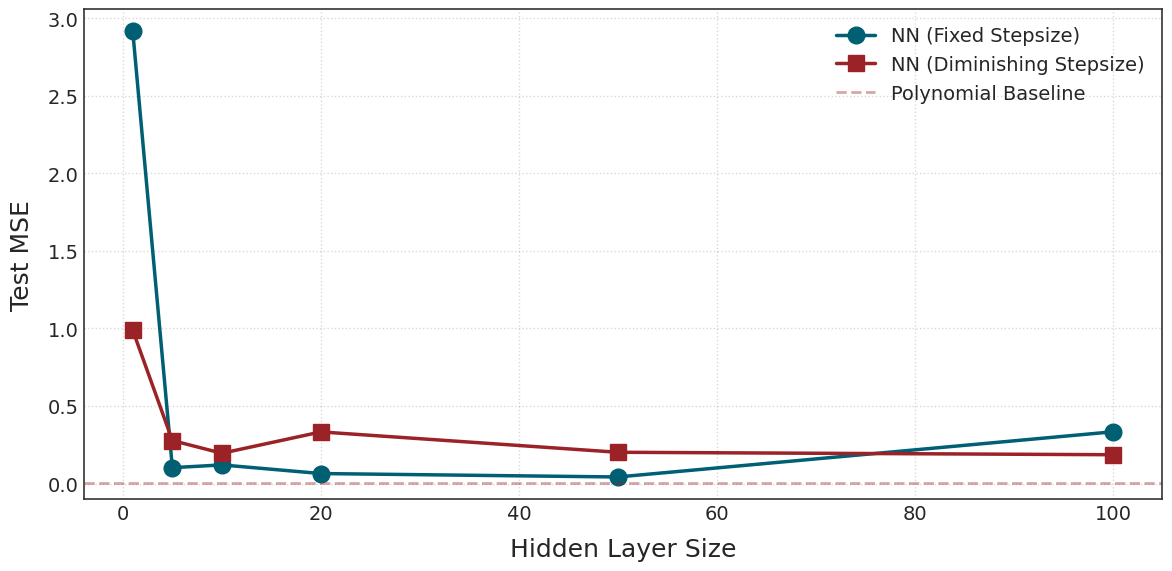

In [ ]:
import matplotlib as mpl
plt.style.use("seaborn-white")


mpl.rcParams.update({
    "font.family": "DejaVu Sans",
    "font.size": 16,
    "axes.edgecolor": "#333333",
    "axes.linewidth": 1.2,
    "axes.titlesize": 22,
    "axes.labelsize": 18,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "legend.frameon": False,
    "axes.spines.top": True,
    "axes.spines.right": True
})

# Create plot
fig, ax = plt.subplots(figsize=(12, 6))

# NN curves
ax.plot(hidden_sizes, nn_test_mse_fixed, marker='o', markersize=12, linewidth=2.5,
        label='NN (Fixed Stepsize)', color='#005F73')
ax.plot(hidden_sizes, nn_test_mse_diminish, marker='s', markersize=12, linewidth=2.5,
        label='NN (Diminishing Stepsize)', color='#9B2226')

# Baseline lines
ax.axhline(poly_mse_diminish, color='#9B2226', linestyle='--', linewidth=2, alpha=0.4, label='Polynomial Baseline')

# Axis labels and title
ax.set_xlabel('Hidden Layer Size', labelpad=10)
ax.set_ylabel('Test MSE', labelpad=10)

# Grid and spines
ax.grid(True, linestyle=':', linewidth=1, color='gray', alpha=0.3)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(True)

# Legend outside
ax.legend(loc='upper right', frameon=False)

# Final layout
plt.tight_layout()
plt.show()
